# TUTORIAL <span style="color:orange;">*ipython_nmr*</span><img width='64' style="float:right;margin:0 10px 0 20px;" src="images/masai.png" />

## Part 7. Inadequate and 2D-fitting

### Various imports and graphics settings

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
# Uncomment one of the two following lines if your want inline figures
#matplotlib.use('nbagg') # this allows having inline graph, which can be modified (i.e., zooming)
%matplotlib inline 

import pylab as pl
pl.style.use('lcsdefault')

### Configuration

In [2]:
from masai.api import *

MASAI api loaded: version 0.2.2.5

The current directory is </Users/christian/Dropbox/PycharmProjects/masai/doc/tutorial>
MASAI root directory is </Users/christian/Dropbox/PycharmProjects/masai>


## Processing and scaling a 2D inadequate spectrum

In [3]:
import os
masai = os.environ.get('MASAI','.')
# You should set the MASAI environnement variable before running these exemples')
# or change the two following paths according to your installation
DATADIR = os.path.join(masai,'doc/tutorial/exemples')
FIGDIR = os.path.join(masai,'doc/tutorial/figures')

In [4]:
user = 'user'
name = 'RUB-17'
expno = 102
path = os.path.join(DATADIR, user,'nmr',name, str(expno))

*Note* : This is a particularly difficult example, as the irradiation offset is far from the lines mass center (This should be avoided in general). 

This notebook is an attempts to correct the scales.

* Here we define a reading/processing function that will be called several times

In [5]:
def get_source():
    """
    read and process a source
    """
    source = Bruker(path) 

    # This is a DQ experiment so:
    source.par2.SFO1 = source.par.SFO1*2.0
    source.par2.SF = source.par.SF*2.0
    # correction due to the missetted ofset
    fn = 2.0 # 2 rotation of the spectra

    source.par2.SF = source.par2.SF + fn * source.par2.SW_h*1.0e-6
    source.data.iloc[:, 512:]=0.0j
    Process(source, transform='em 1')
    Process(source, transform='zf 3') 
    Process(source, transform='ft')
    Process(source, transform='cl -99 -80')
    Process(source, transform='pk 0 0 --auto --fit_phc1')
    Process(source, transform='ab --mode poly')

    # 2nd dimension
    Process(source, axis=0, transform='em 1')
    Process(source, axis=0, transform='zf 2') 
    Process(source, axis=0, transform='ft')
    Process(source, axis=0, transform = 'cl -198 -170')
    Process(source, axis=0, transform='pk 180 0 --auto --fit_phc1 --select cols')
    
    #Process(source, transform = 'mc')
    Process(source, transform = 'ab --mode linear')
    Process(source, axis=0, transform = 'ab --mode linear')
    
    return source

* then we call this function and display the result

In [6]:
source = get_source()
# plot
p = Plot2d(source, figsize=(5,3.7), nc=5, exponent=1.2, xproj='sky')

# plot the diagonal
d, = p.axe.plot(source.data.columns, source.data.columns*2.0, lw=.1, ls='--')

#TODO: make this simple in the Plot2d plugin

removed 152
Loaded SER
Exponential apodization lb:1.00
Zero-filling to si:16384
Fourier transform with si:16384
clipping along axis -1
Auto-phasing :  phc0 = 140.611, phc1 = -0.328
baseline correction mode:poly
Exponential apodization lb:1.00
Zero-filling to si:256
Data transform according to encoding STATES
Fourier transform with si:256
clipping along axis 0
Auto-phasing :  phc0 = 341.066, phc1 = 0.009
baseline correction mode:linear
baseline correction mode:linear


<IPython.core.display.Javascript object>

## Fitting of the 2Q spectrum

First we make a function to create a fitting script from some information

In [7]:
def make_script(species, fixed_pos, missing_connections, ampl0, width, width1, theta,  limits=None, limits1=None):
    """
    Create a script to be used for fitting SQ-DQ spectra
    
    """
    script  = "COMMON:"
    if not isinstance(width, tuple) and not isinstance(width, list):
        width = (width, 0.1, 3.0)
    if not isinstance(width1, tuple) and not isinstance(width, list):
        width1 = (width1, 0.1, 3.0)
    print width, width1
    script +="\n $ gwidth: %.3f, %.3f, %.3f"%tuple(width)
    script +="\n $ gwidth1: %.3f, %.3f, %.3f"%tuple(width1)
    script +="\n $ gtheta: %.3f, %.3f, %.3f"%tuple(theta)
    for i, key in enumerate(species.keys()):
        # additional common parameters
        v = species[key]
        ft = '*' if key in fixed_pos else '$' 
        script += "\n %s gpos%s: %.3f, %.3f, %.3f"%(ft, key, v, v-width[0], v+width[0])

    for i, key in enumerate(species.keys()):
        for j, key1 in enumerate(species.keys()):
            # as it is normally symmetric we can try to reduce the number of varaible
            v = species[key]
            v1 = species[key1]
            
            if j<i or '%s%s'%(key,key1) in missing_connections:
                 continue # bypass
        
            if limits1 and (v+v1 < limits1[0] or v+v1 > limits1[1]):
                 continue  # bypass
                    
            script += "\n\n MODEL: LINE_"+key+key1
            script += "\n shape: gaussian2dmodel"
            script += "\n $ ampl:  %.3f, 0.0, none"%ampl0
            script += "\n > pos: gpos%s "%key
            script += "\n > pos1: (gpos%s) + (gpos%s)"%(key, key1)
            script += "\n > width: gwidth"
            script += "\n > width1: gwidth1"
            script += "\n > theta: gtheta"

    script = script.lower()
    return script


Lets go to the bottom part of the spectrum first

removed 152
Loaded SER
Exponential apodization lb:1.00
Zero-filling to si:16384
Fourier transform with si:16384
clipping along axis -1
Auto-phasing :  phc0 = 140.611, phc1 = -0.328
baseline correction mode:poly
Exponential apodization lb:1.00
Zero-filling to si:256
Data transform according to encoding STATES
Fourier transform with si:256
clipping along axis 0
Auto-phasing :  phc0 = 341.066, phc1 = 0.009
baseline correction mode:linear
baseline correction mode:linear
clipping along axis 0
limits: [-98.970588799965583, -80.001505038591205]
limits1: [-179.82516502248254, -172.12806287356375]
baseline correction mode:linear
baseline correction mode:linear


<IPython.core.display.Javascript object>


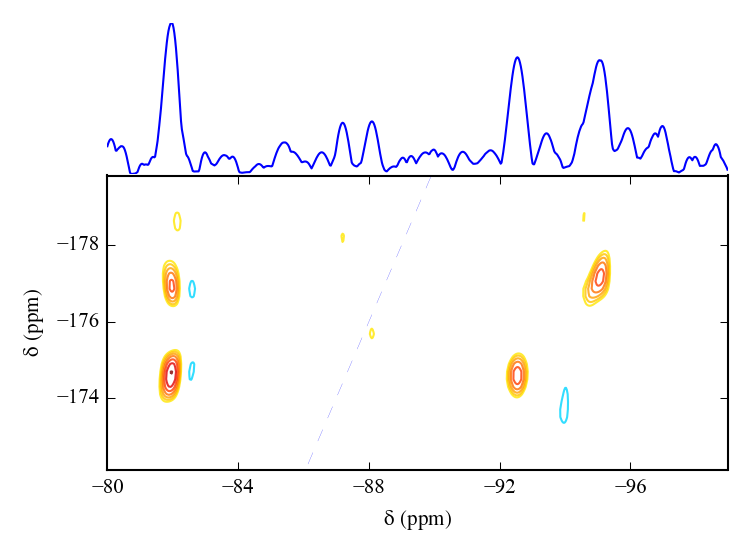

'spacing' is deprecated, use 'nc' instead.


In [8]:
source = get_source()

limits = None
limits1 = (-180, -172)

# We use some restricted part of the spectrum
if limits:
    Process(source, transform = 'cl %.3f %3f'%limits)
if limits1:
    Process(source, axis=0, transform = 'cl %.3f %3f'%limits1)
limits = [source.data.columns[0], source.data.columns[-1]]
limits.sort()
limits1 = [source.data.index[0], source.data.index[-1]]
limits1.sort()
print "limits:", limits
print "limits1:", limits1

# make polynomial baseline correction
Process(source, transform='ab')
Process(source, axis=0,  transform='ab')
# plot
p = Plot2d(source, figsize=(5,3.7), spacing=3, exponent=1.2, xproj='sky')

# plot the diagonal
p.axe.plot(source.data.columns, source.data.columns*2.0, lw=.1, ls='--')

In [9]:
FIT = True

# ordered dictionnary of species
spc={
    'A': -81.95,
    'B': -92.55,
    'C': -92.7,
    'D': -93.9,
    'E': -94.2,
    'F': -94.9,
    'G': -95.13,
    }
# make a dictionary sorted by key
from collections import OrderedDict
species = OrderedDict(sorted(spc.items(), key=lambda t: t[0]))
print(species)

#create a connectivity table
connectivities = np.zeros((len(spc), len(spc)))
connectivities = pd.DataFrame(connectivities.astype(int), index=species.keys(), columns=species.keys())

fixed_pos = ('C', 'D', 'E', 'F')
missing_connections = ('AA', 'AC', 'AD', 'AE', 'AG',) 

width =  (0.4, 0.2, 3.0)
width1 = (1.5, 0.2, 3.0)
theta = (0, -10, 45)
ampl0 = source.data.values.max()

script = make_script(species, fixed_pos, missing_connections, ampl0, width, width1, theta, limits, limits1)

# Start fit
############
f = Fit(source,  script, kind='SQ-DQ')
if FIT: 
    f.run(maxiter=20000, maxfun=10000, every=50)    

# results
###########
# update species table
keys = f.fp.keys()
keys.sort()
for key in keys:
    if 'gpos' in key:
        species[key[-1].upper()] = f.fp[key]        

# update connectivity table
for key in keys:
    if 'pos1' in key:
        connect = key[-2:]
        key = 'ampl_line_'+connect # get amplitude
        #i = species.keys().index(connect[0].upper())
        #j = species.keys().index(connect[1].upper())
        ki = connect[0].upper()
        kj = connect[1].upper()
        connectivities.loc[ki, kj]=connectivities.loc[kj,ki]=int(f.fp[key])

Iterations: 450, Calls: 723 (chi2: 0.80527)
The number of experiment(s) is set to 1

Result:
#PARAMETER SCRIPT

COMMON: 
	$ gwidth: 0.497447700152, 0.2, 3.0 
	* gposd: -93.9, -94.3, -93.5 
	* gpose: -94.2, -94.6, -93.8 
	* gposf: -94.9, -95.3, -94.5 
	$ gposa: -81.95, -82.35, -81.55 
	$ gposb: -92.55, -92.95, -92.15 
	$ gposg: -95.13, -95.53, -94.73 
	$ gtheta: 9.17583069783, -10.0, 45.0 
	* gposc: -92.7, -93.1, -92.3 
	$ gwidth1: 1.02524009098, 0.2, 3.0 

MODEL: line_ab
shape: gaussian2dmodel
	> width: gwidth 
	> pos: gposa 
	$ ampl: 0.0836754993708, 0.0, none 
	> pos1: (gposa) + (gposb) 
	> theta: gtheta 
	> width1: gwidth1 

MODEL: line_af
shape: gaussian2dmodel
	> width: gwidth 
	> pos: gposa 
	$ ampl: 0.0670331487555, 0.0, none 
	> pos1: (gposa) + (gposf) 
	> theta: gtheta 
	> width1: gwidth1 



<IPython.core.display.Javascript object>


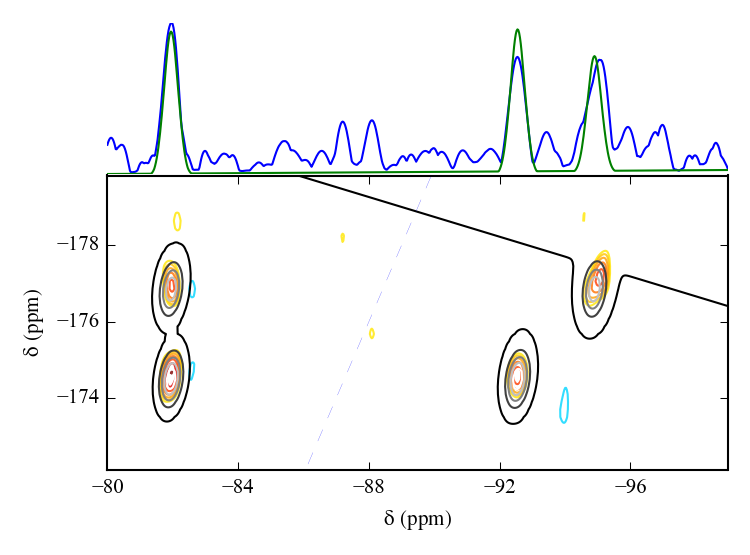

In [10]:
# plot
#p_1 = Plot2d(source, figsize=(5,3.7), spacing=3, exponent=1.2, xproj='sky')

# plot the diagonal
#p_1.axe.plot(source.data.columns, source.data.columns*2.0, lw=.1, ls='--')

#p_1.show()

# plot
p_2 = Plot2d(source, figsize=(5,3.7), nc=3, exponent=1.2, xproj='sky')

# plot the diagonal
p_2.axe.plot(source.data.columns, source.data.columns*2.0, lw=.1, ls='--')

x = source.data.columns
y = source.data.index
p_2.axe.contour(x, y, source.modeldata, 5, cmap='gray')
p_2.axex.plot(x, source.modeldata.max(axis=0))
p_2.show()

In [11]:
def draw_connection(ax, species, conn) :
    for ki in conn.columns:
        for kj in conn.index:
            A = species[ki]
            B = species[kj]
            if A<B or conn.loc[ki, kj]<.01: 
                continue
            ax.plot((A,B), (A+B, A+B)) # plot line
    
            xt, yt = (A+B)/2., A+B
           # if xytext:
           #     xs, ys = xytext
           #     xt, yt = xt+xs, yt+ys
                
            dp=dict(boxstyle="round, pad=0", fc="w", ec="w", alpha=0.95)
            ax.text(xt, yt, '%s-%s'%(ki,kj), ha='center', va='center', bbox=dp, fontsize=6)
            


   A  B  C  D  E  F  G
A  0  0  0  0  0  0  0
B  0  0  0  0  0  0  0
C  0  0  0  0  0  0  0
D  0  0  0  0  0  0  0
E  0  0  0  0  0  0  0
F  0  0  0  0  0  0  0
G  0  0  0  0  0  0  0


<IPython.core.display.Javascript object>


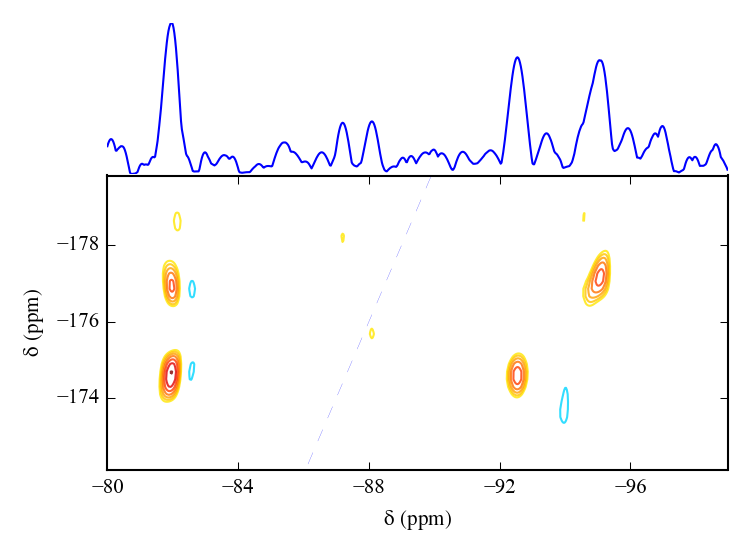

'spacing' is deprecated, use 'nc' instead.


In [12]:
# write the table
conn= connectivities/10
conn = conn.astype(int)
print conn

# plot
p_1 = Plot2d(source, figsize=(5,3.7), spacing=3, exponent=1.2, xproj='sky')

# plot the diagonal
p_1.axe.plot(source.data.columns, source.data.columns*2.0, lw=.1, ls='--')

draw_connection(p_1.axe, species, conn)

p_1.show()

* Now we work with the top right part

In [13]:
source = get_source()

limits = (-97,-91) 
limits1 = (-2*97, -2*91)

# We use some restricted part of the spectrum
if limits:
    Process(source, transform = 'cl %.3f %3f'%limits)
if limits1:
    Process(source, axis=0, transform = 'cl %.3f %3f'%limits1)
limits = [source.data.columns[0], source.data.columns[-1]]
limits.sort()
limits1 = [source.data.index[0], source.data.index[-1]]
limits1.sort()
print "limits:", limits
print "limits1:", limits1

# make polynomial baseline correction
Process(source, transform='ab')
Process(source, axis=0,  transform='ab')

# plot
p = Plot2d(source, figsize=(5,3.7), spacing=5, exponent=1.1, xproj='sky')

# plot the diagonal
p.axe.plot(source.data.columns, source.data.columns*2.0, lw=.1, ls='--')

removed 152
Loaded SER
Exponential apodization lb:1.00
Zero-filling to si:16384
Fourier transform with si:16384
clipping along axis -1
Auto-phasing :  phc0 = 140.611, phc1 = -0.328
baseline correction mode:poly
Exponential apodization lb:1.00
Zero-filling to si:256
Data transform according to encoding STATES
Fourier transform with si:256
clipping along axis 0
Auto-phasing :  phc0 = 341.066, phc1 = 0.009
baseline correction mode:linear
baseline correction mode:linear
clipping along axis -1
clipping along axis 0
limits: [-96.973843140873541, -91.009205466919113]
limits1: [-193.83783816538596, -182.1935041452268]
baseline correction mode:linear
baseline correction mode:linear


<IPython.core.display.Javascript object>

'spacing' is deprecated, use 'nc' instead.


In [14]:
fixed_pos = ('A', 'B', 'G')
missing_connections = ('AA', 'AC', 'AD', 'AE', 'AG',) 

script = make_script(species, fixed_pos, missing_connections, ampl0, width, width1, theta, limits, limits1)

# Start fit
############
f = Fit(source,  script, kind='SQ-DQ')
if FIT: 
    f.run(maxiter=1000, maxfun=2000, every=50)
print(f.script)

# results
###########
# update species table
keys = f.fp.keys()
keys.sort()
for key in keys:
    if 'gpos' in key:
        species[key[-1].upper()] = f.fp[key]        

# update connectivity table
for key in keys:
    if 'pos1' in key:
        connect = key[-2:]
        key = 'ampl_line_'+connect # get amplitude
        ki = connect[0].upper()
        kj = connect[1].upper()
        connectivities.loc[ki, kj] = connectivities.loc[kj,ki] = int(f.fp[key])

Iterations: 950, Calls: 1113 (chi2: 0.48127)
The number of experiment(s) is set to 1

Result:
#PARAMETER SCRIPT

COMMON: 
	$ gtheta: 16.3656453073, -10.0, 45.0 
	$ gwidth1: 1.35883102691, 0.2, 3.0 
	$ gwidth: 0.491625365036, 0.2, 3.0 
	$ gposd: -93.9, -94.3, -93.5 
	$ gpose: -94.2, -94.6, -93.8 
	$ gposf: -94.9, -95.3, -94.5 
	* gposg: -95.13, -95.53, -94.73 
	* gposa: -81.95, -82.35, -81.55 
	* gposb: -92.55, -92.95, -92.15 
	$ gposc: -92.7, -93.1, -92.3 

MODEL: line_bb
shape: gaussian2dmodel
	> width1: gwidth1 
	$ ampl: 49.1285911913, 0.0, none 
	> pos: gposb 
	> theta: gtheta 
	> width: gwidth 
	> pos1: (gposb) + (gposb) 

MODEL: line_bc
shape: gaussian2dmodel
	> width1: gwidth1 
	$ ampl: 16.0158983391, 0.0, none 
	> pos: gposb 
	> theta: gtheta 
	> width: gwidth 
	> pos1: (gposb) + (gposc) 

MODEL: line_bd
shape: gaussian2dmodel
	> width1: gwidth1 
	$ ampl: 132.949770535, 0.0, none 
	> pos: gposb 
	> theta: gtheta 
	> width: gwidth 
	> pos1: (gposb) + (gposd) 

MODEL: line_be
shap

Maximum number of iterations reached.


In [15]:
# results
###########
# update species table
keys = f.fp.keys()
keys.sort()
for key in keys:
    if 'gpos' in key:
        species[key[-1].upper()] = f.fp[key]        

# update connectivity table
for key in keys:
    if 'pos1' in key:
        connect = key[-2:]
        key = 'ampl_line_'+connect # get amplitude
        ki = connect[0].upper()
        kj = connect[1].upper()
        connectivities.loc[ki, kj] = connectivities.loc[kj,ki] = int(f.fp[key])

<IPython.core.display.Javascript object>


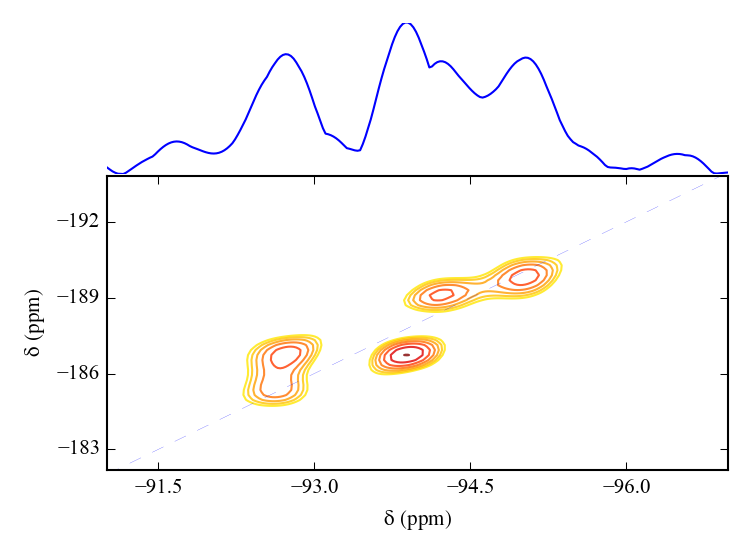

'spacing' is deprecated, use 'nc' instead.


<IPython.core.display.Javascript object>

'spacing' is deprecated, use 'nc' instead.


In [16]:
# plot
p_1 = Plot2d(source, figsize=(5,3.7), spacing=3, exponent=1.2, xproj='sky')

# plot the diagonal
p_1.axe.plot(source.data.columns, source.data.columns*2.0, lw=.1, ls='--')

p_1.show()

# plot
p_2 = Plot2d(source, figsize=(5,3.7), spacing=3, exponent=1.2, xproj='sky')

# plot the diagonal
p_2.axe.plot(source.data.columns, source.data.columns*2.0, lw=.1, ls='--')

x = source.data.columns
y = source.data.index
p_2.axe.contour(x, y, source.modeldata, 5, cmap='gray')
p_2.axex.plot(x, source.modeldata.max(axis=0))
p_2.show()

Display the connectivity table

In [17]:
# write the table
conn= connectivities
conn = conn.astype(int)
print conn

# plot
p_1 = Plot2d(source, figsize=(5,3.7), spacing=3, exponent=1.2, xproj='sky')

# plot the diagonal
p_1.axe.plot(source.data.columns, source.data.columns*2.0, lw=.1, ls='--')

draw_connection(p_1.axe, species, conn)

p_1.show()

   A    B   C    D   E   F   G
A  0    0   0    0   0   0   0
B  0   49  16  132   0  17  30
C  0   16  42   85  46  14   0
D  0  132  85    0   0   4   0
E  0    0  46    0  34  85  43
F  0   17  14    4  85  44  26
G  0   30   0    0  43  26  47


<IPython.core.display.Javascript object>

'spacing' is deprecated, use 'nc' instead.


In [18]:
print species

OrderedDict([('A', -81.95), ('B', -92.55), ('C', -92.7), ('D', -93.9), ('E', -94.2), ('F', -94.9), ('G', -95.13)])


Graph analysis of connectivities

In [19]:
# write the table + Zn_atoms
conn= connectivities
conn = conn.astype(int)
#conn['Z1']=pd.Series([40, 6, 6, 6, 6, 6, 6],index=conn.index)
#conn['Z2']=pd.Series([40, 6, 6, 6, 6, 6, 6],index=conn.index)
print conn

   A    B   C    D   E   F   G
A  0    0   0    0   0   0   0
B  0   49  16  132   0  17  30
C  0   16  42   85  46  14   0
D  0  132  85    0   0   4   0
E  0    0  46    0  34  85  43
F  0   17  14    4  85  44  26
G  0   30   0    0  43  26  47
